# MNIST - Loading, Training and Evaluation

This notebook covers the main stages in Deep Learning, acting as an introduction to both the PyTorch platform as well as some impotant steps when loading data, defining a model, training and evaluation.

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../../util')
import vcpi_util

print(torch.__version__)

2.2.1+cu118


# Check GPU availability


In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Load the dataset from torch collection of datasets

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor()]) #, transforms.RandomHorizontalFlip(1.0)])


train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

In [17]:
print(train_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [18]:
print("Classes: ", train_set.classes)

print("Dataset shape: ", train_set.data.shape)

Classes:  ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Dataset shape:  torch.Size([60000, 28, 28])


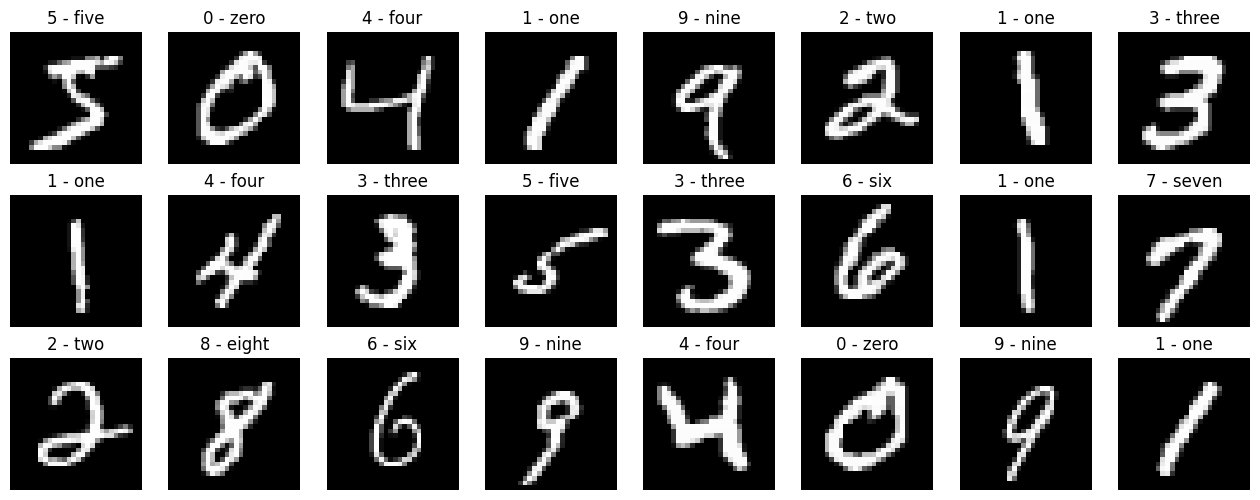

<Figure size 640x480 with 0 Axes>

In [19]:
# these are the images we loaded. 
vcpi_util.show_loaded_images(3,8, train_set, train_set.classes)

Data loaders provide an efficient way to load data into a model for training purposes. These loaders allow us to use datasets that do not fit in memory.

Loaders also divide the training set in batches, and provide shuffling functionality at the end of each epoch, ensuring that the batches vary from epoch to epoch.

In [20]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False)

In [21]:
print("Training set samples: ", len(train_loader.dataset))

# this will give the total number of batches, but note that the last batch may not be complete
print("Training set batches", len(train_loader))

print ("Test set samples: ", len(test_loader.dataset))



Training set samples:  60000
Training set batches 469
Test set samples:  10000


In [22]:
images, targets = next(iter(train_loader))
print("Batch shape: ", images.shape)
img_np = images.numpy()
print("Each image varies between ",np.min(img_np)," and ", np.max(img_np))

# putting channels last so that the image can be displayed
img_np = np.transpose(img_np,(0,2,3,1))
print("Shape after channel transpose :", img_np.shape)

Batch shape:  torch.Size([128, 1, 28, 28])
Each image varies between  0.0  and  1.0
Shape after channel transpose : (128, 28, 28, 1)


## Display images using the data loader

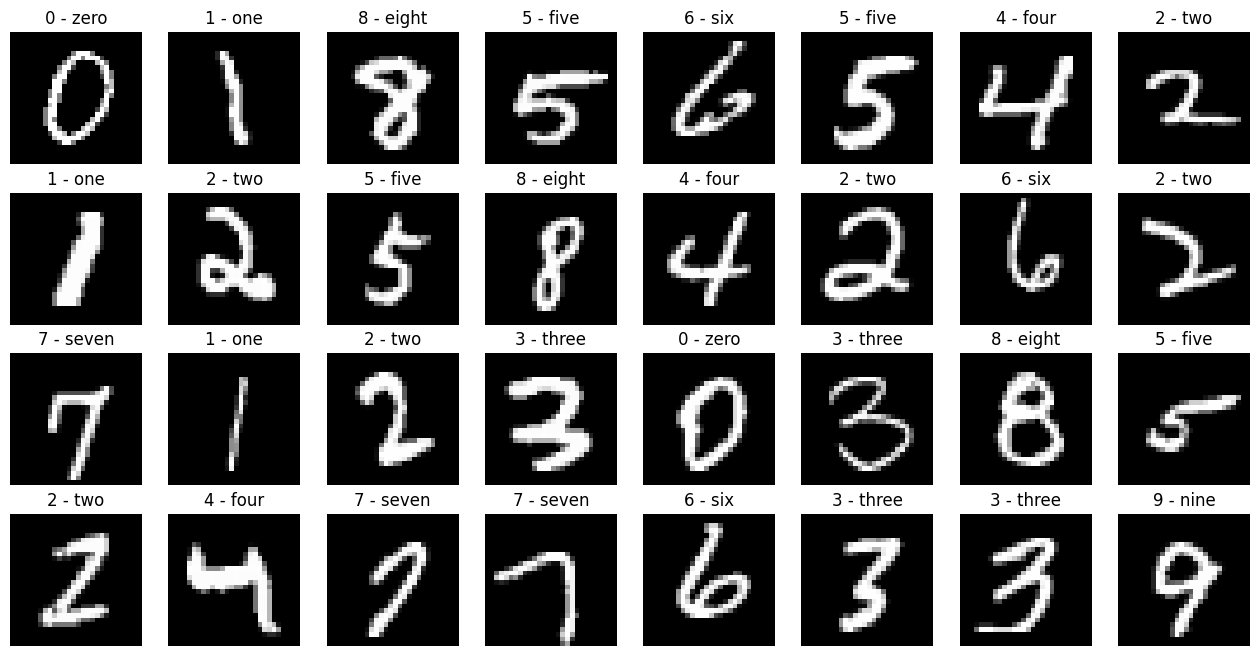

<Figure size 640x480 with 0 Axes>

In [23]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(4,8, images, targets, train_set.classes) 

## Class distribution

A dataset is considered balanced if no class has a significantly higher number of samples than some other class

When training an imbalanced dataset, there is always the danger that the model will prioritize  the more represented classes, as this will decrease the loss faster. This can lead to biased predictions.

Checking the dataset to see if it is balanced can be easily done with an histogram of occurrences per class.

Solutions to overcome this problem include data augmentation and class weighting, more on this in later lectures.

MNIST is a fairly balanced dataset so we don't have to worry about this in here. 

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


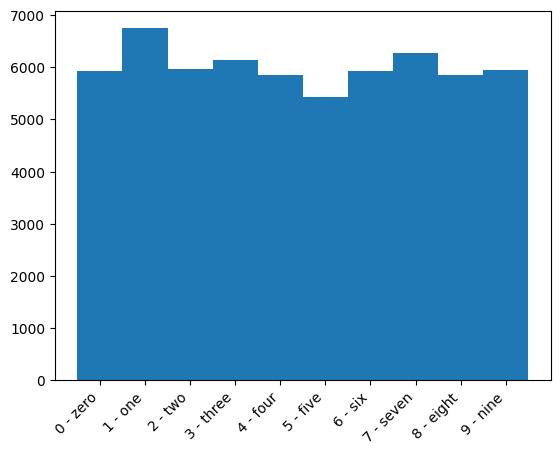

In [24]:
vcpi_util.show_histogram(train_set.targets, train_set.classes)

# Create model

Define a fully connected model with:
 
- an input layer that flattens the 28x28 input images into a vector of 784 values;

- a single hidden layer with 64 units;

- an output layer with 10 units, one per class.


In [25]:
class FullyConnected_I(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 64)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(64,10)       

    def forward(self, x):    

        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return(x)


In [26]:
model = FullyConnected_I()

# send model to GPU
model.to(device)

print(model)

FullyConnected_I(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [27]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FullyConnected_I                         [128, 10]                 --
├─Linear: 1-1                            [128, 64]                 50,240
├─ReLU: 1-2                              [128, 64]                 --
├─Linear: 1-3                            [128, 10]                 650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.51
Input size (MB): 0.40
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.68

## Some predictions with an untrained model

We use an iterator on test_loader to get the first batch. Then ask the model for predictions on the images.

In [28]:
images, targets = next(iter(test_loader))

# feed the images to the model. The return value is the output layer outputs for each image in the batch
logits = model(images.to(device))

# the return value is a tensor residing on device, GPU if available
print(logits[0])

# convert to probabilities, moving to CPU, detaching from compute compute graph and convert to numpy
predictions = torch.nn.functional.softmax(logits,dim=1).cpu().detach().numpy()
print(predictions[0])



tensor([-0.1845,  0.1072,  0.0422, -0.1336, -0.0600, -0.1226, -0.2171, -0.1190,
         0.0160, -0.0144], device='cuda:0', grad_fn=<SelectBackward0>)
[0.08861414 0.11862896 0.11115938 0.09324127 0.10036022 0.09427162
 0.08577428 0.09461341 0.10829025 0.10504649]


Showing the first batch and the predictions. In blue is the true class, in red the predicted class. When the model is initialized with random weights it is normal to have all predictions wrong. Notice also that the model has no confidence in general in its predicitons, with the predicted class getting always a low score.

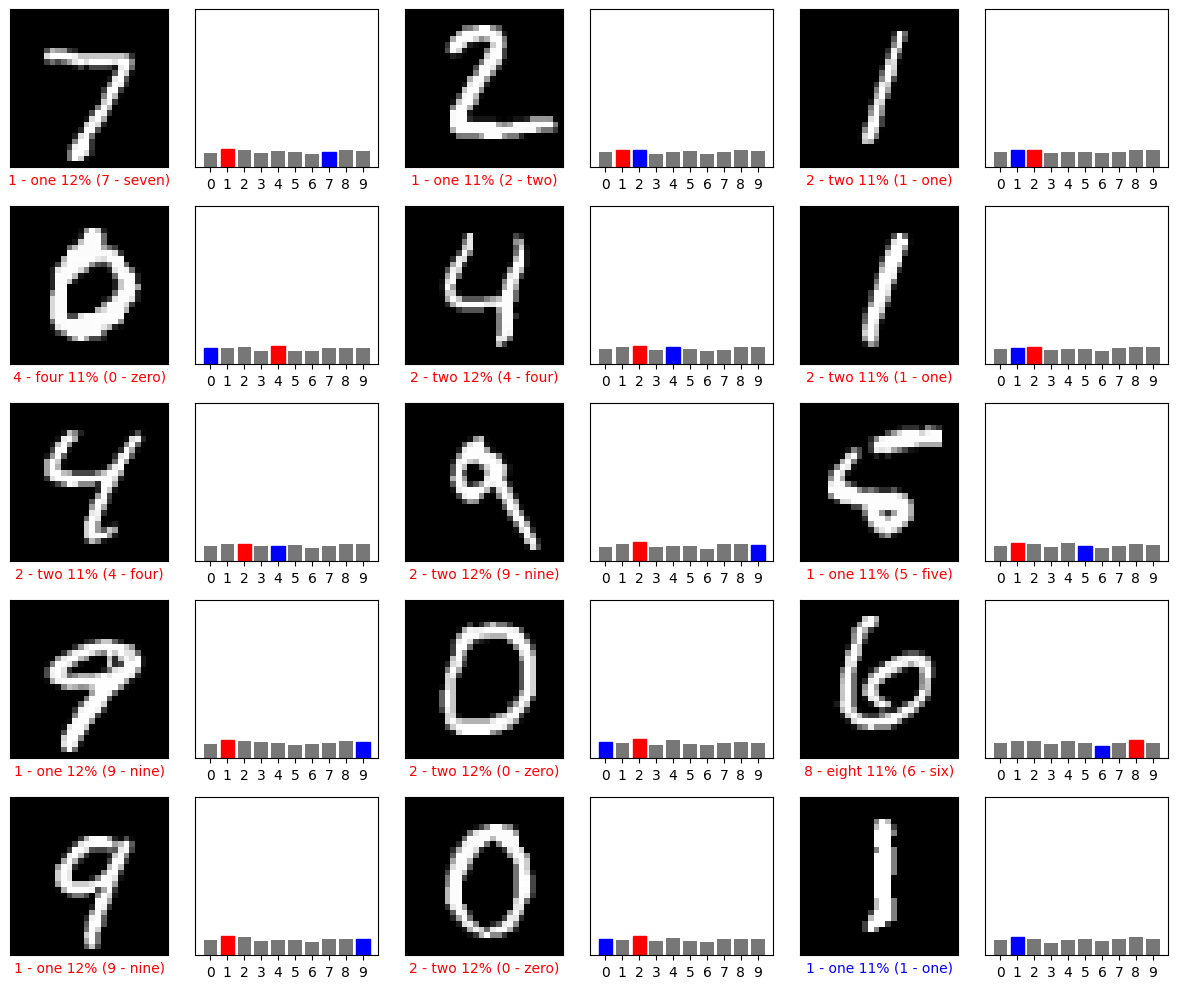

In [29]:
vcpi_util.plot_predictions(images, predictions, targets, train_set.classes, 5, 3)

# Evaluating the model

In [30]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


When evaluating a model prior to any training the accuracy should be approximately 1/#classes.

In [31]:
evaluate(model, test_loader)

0.13600000739097595

# Train the model 

To train a model a loss function and an optimizer are required. In here we are selecting the Adam optimizer provided by Torch, and the sparse categorical cross entropy, which is common in multi-class classification problems. 

Since the $CrossEntropyLoss$ function internally applies the softmax function, the model's output layer should not use softmax as its activation function.

In torch, the optimizer receives the model's parameters, in order to be able to update all the learning parameters of the model.

The Adam optimizer has a set of parameters that can be set when defining the optimizer. See [Torch Adam page](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

For further info on Torch optimizers see [Torch optimizer documentation page](https://pytorch.org/docs/stable/optim.html).

Torch documentation on [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [32]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

This is a typical training loop for a classification problem. It runs for a number of epochs, exposing the model to the full training set repeatedly.

In each epoch, the loop iterates over batches, performing the following steps:

 - feeds the batch to the model
 - compute the loss and gradients
 - update the model's weights using the optimizer.

In [33]:
def train(model, data_loader, epochs):

    # sets the model in training mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.train()

    history = {}
    history['accuracy'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(data_loader, 0):
            
            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)
            
            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        accuracy = 100 * correct / len(train_set)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Accuracy = {accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
        
    print('Finished Training')

    return(history)
                

In [34]:
epochs = 3
history = train(model, train_loader, epochs)

Epoch: 000; Accuracy = 88.1850; Elapsed time: 6.2615
Epoch: 001; Accuracy = 93.1400; Elapsed time: 6.1137
Epoch: 002; Accuracy = 94.5400; Elapsed time: 6.0462
Finished Training


# Saving the model

documentation: [Saving and Loading Models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

The first option is to use the "save" function with a dictionary of items to be saved. This allows not only to save the state of the model, useful for inference, but also the optimizer, useful for continuing training. Furthermore, user defined information can be added to the dictionary.

This allow to recreate the model and optimizer in exactly the same state as when they were saved. Note that when loading the model, the class which it instantiates must be known.

In [36]:
###### Saving ######
torch.save({
    'epoch': epochs,
    'model':model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'history' : history
    },
    f'model_IV_optimizer_{epochs}.pt')


###### Loading ######
# recreate the model and optimizer
retrieved_model = FullyConnected_I()
retrieved_optimizer = torch.optim.Adam(retrieved_model.parameters())

#load the dict
retrieved = torch.load(f'model_IV_optimizer_{epochs}.pt')

# set the model and optimizer state to the saved state
retrieved_model.load_state_dict(retrieved['model'])
retrieved_model.to(device)
retrieved_optimizer.load_state_dict(retrieved['optimizer'])

evaluate(retrieved_model, train_loader)

0.9545333385467529

The result of evaluating the loaded model is different from the value printed for the last epoch in the training procedure. Why?

The difference arises because the training accuracies are computed as an average of the accuracies per batch while the model is *still learning*, whereas the final evaluation was performed after the model has been trained.

In [24]:
print(retrieved['history'])

{'accuracy': [array(87.53167, dtype=float32), array(93.265, dtype=float32), array(94.76, dtype=float32)], 'loss': [array(226.78627, dtype=float32), array(111.07634, dtype=float32), array(86.001366, dtype=float32)]}


The second option works only for inference, and uses TorchScript, which provides an intermediate representation of a model. This can then be loaded without any knowledge of the underlying class used to create the model.

In [37]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # save


model = torch.jit.load('model_scripted.pt') # load
evaluate(model, train_loader) # evaluate

0.9545333385467529

## History graphs for accuracy and loss


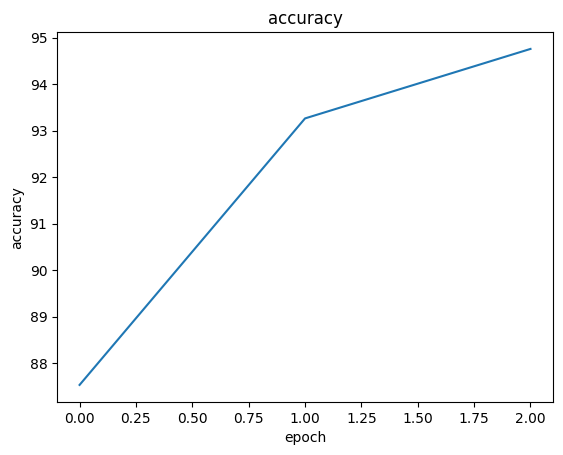

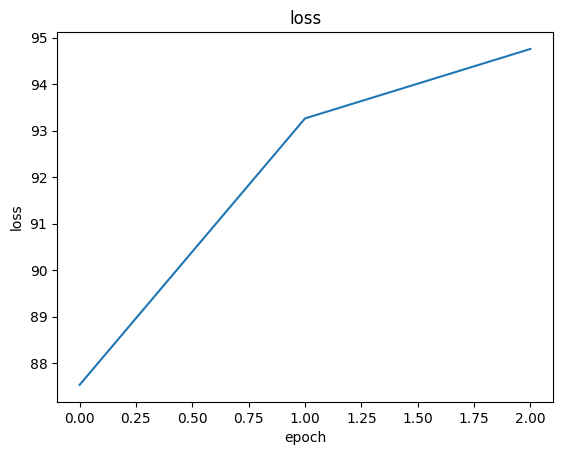

In [27]:
vcpi_util.show_history(history)

# Evaluate the model on the test set

In [28]:
evaluate(  model, test_loader)

0.9502999782562256

## Show 15 examples from the test set

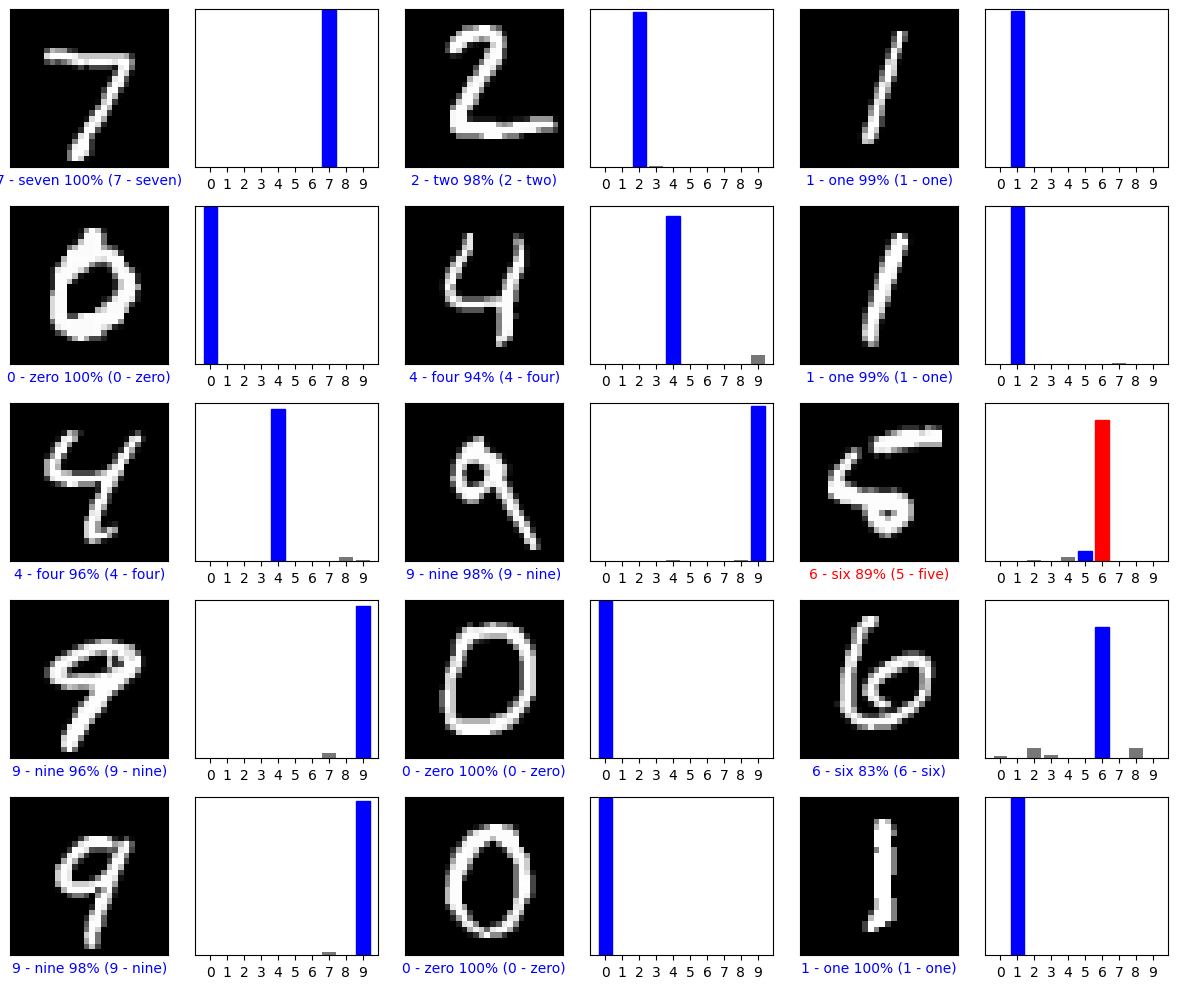

In [29]:
images, targets = next(iter(test_loader))
logits = model(images.to(device))

predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, predictions, targets, train_set.classes, 5, 3)

## Some misclassified samples from test set

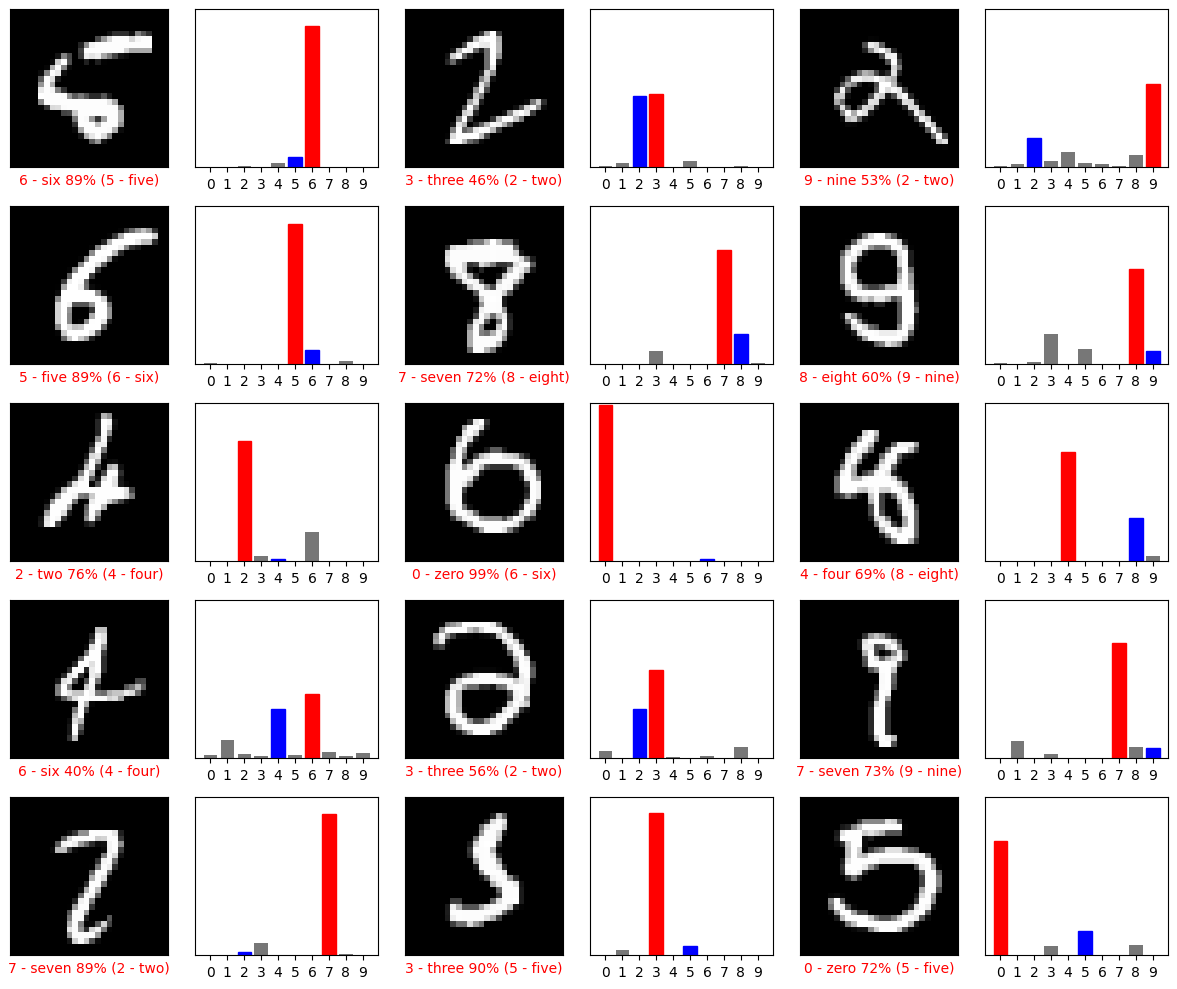

In [30]:

k = 0
iters = 0

preds = []
ground_truth = []
imgs = torch.Tensor(15, 1, 28,28)

iterator = iter(test_loader)

max_iters = test_set.__len__() / BATCH_SIZE
while k < 15 and iters < max_iters:

    images, targets = next(iterator)
    #print(images[0].shape)
    logits = model(images.to(device))
    
    #print(predictions[0])
    predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
    for i in range(len(predictions)):

        if np.argmax(predictions[i]) != targets[i] and k < 15:

            preds.append(predictions[i])
            ground_truth.append(targets[i])
            imgs[k, :, :, :] = images[i]
            k += 1

    iters += 1

vcpi_util.plot_predictions(imgs, preds, ground_truth, train_set.classes, 5, 3)

# Confusion Matrix

In [31]:
preds = []
ground_truth = []

for images, targets in test_loader:

    logits = model(images.to(device))
    preds_sparse = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_sparse)
    ground_truth.extend(targets.numpy())



In a confusion matrix, each row represents a true class. The columns in that row indicate the number , or the percentage, of samples from that class that were predicted as belonging to each possible class.

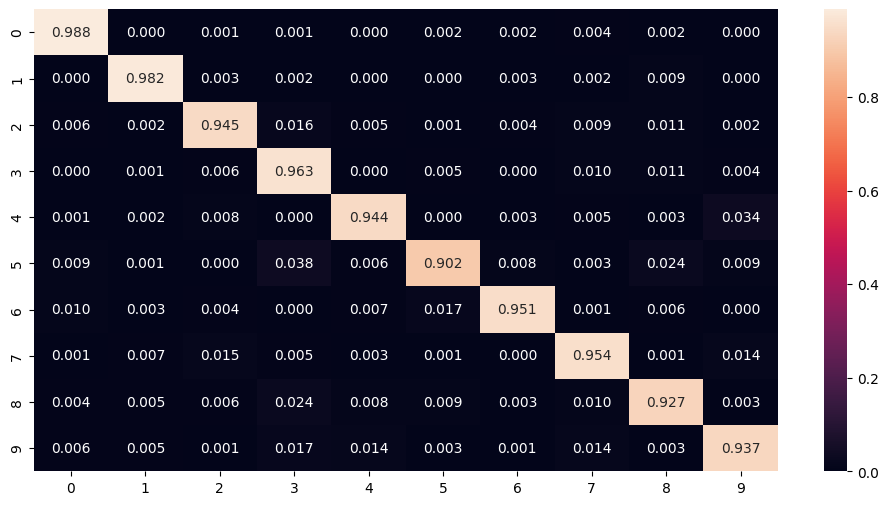

In [32]:
vcpi_util.show_confusion_matrix(ground_truth, preds, len(train_set.classes))